# Mentoria Data Science Academy

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Downloads do pacote NLTK
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## 0.0 Carregando os Dados

In [2]:
data_path = 'dados'
df1 = pd.read_csv(os.path.join(data_path, 'posts.csv'), sep = '|')
df2 = pd.read_csv(os.path.join(data_path, 'posts_2.csv'), sep = '|')
df3 = pd.read_csv(os.path.join(data_path, 'posts_3.csv'), sep = '|')

In [3]:
df1.head()

,title,date,answers,visits,url,post,area
0,recurso cabível exceção de preexecutividade re...,11 de Março de 2021,1,1,threads/recurso-cabivel-excecao-de-preexecutiv...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros...",direito-do-trabalho.17
1,Liquidez - Reforma Trabalhista,06 de Março de 2021,0,6,threads/liquidez-reforma-trabalhista.23092/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas...",direito-do-trabalho.17
2,Rito Sumário - sentença irrecorrível?,06 de Março de 2021,0,6,threads/rito-sumario-sentenca-irrecorrivel.23091/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tOlá, colegas.\r\n\...",direito-do-trabalho.17
3,DISPENSA DE FUNCIONARIO AFASTADO EM ESPECIE DE...,27 de Janeiro de 2021,0,9,threads/dispensa-de-funcionario-afastado-em-es...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tPrezados, Drs.\r\n...",direito-do-trabalho.17
4,Cálculo Trabalhista - contador ou advogado?,03 de Maio de 2018,8,1,threads/calculo-trabalhista-contador-ou-advoga...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tQueridos (as),\r\n...",direito-do-trabalho.17


In [4]:
df = pd.concat([df1, df2, df3], axis = 0)

In [5]:
# As colunas visits e likes não estão presentes em todos os dfs, então vamos remove-las 
df.drop(columns=['visits', 'likes'], inplace=True)

In [6]:
df.head()

,title,date,answers,url,post,area
0,recurso cabível exceção de preexecutividade re...,11 de Março de 2021,1,threads/recurso-cabivel-excecao-de-preexecutiv...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros...",direito-do-trabalho.17
1,Liquidez - Reforma Trabalhista,06 de Março de 2021,0,threads/liquidez-reforma-trabalhista.23092/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas...",direito-do-trabalho.17
2,Rito Sumário - sentença irrecorrível?,06 de Março de 2021,0,threads/rito-sumario-sentenca-irrecorrivel.23091/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tOlá, colegas.\r\n\...",direito-do-trabalho.17
3,DISPENSA DE FUNCIONARIO AFASTADO EM ESPECIE DE...,27 de Janeiro de 2021,0,threads/dispensa-de-funcionario-afastado-em-es...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tPrezados, Drs.\r\n...",direito-do-trabalho.17
4,Cálculo Trabalhista - contador ou advogado?,03 de Maio de 2018,8,threads/calculo-trabalhista-contador-ou-advoga...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tQueridos (as),\r\n...",direito-do-trabalho.17


In [7]:
df['area'] = df['area'].apply(lambda x: x.split('.')[0])

## 1.0 Descrição dos dados

### 1.1 Dimensão dos dados

In [8]:
print("Número de exemplos:", df.shape[0])
print("Número de colunas:", df.shape[1])

Número de exemplos: 39016
Número de colunas: 6


### 1.2 Tipo das colunas

In [9]:
# Mostra o tipo de cada variável
df.dtypes

title      object
date       object
answers     int64
url        object
post       object
area       object
dtype: object

Precisamos converter a variável date para formato de data para então podermos utilizar informações como dia da semana, fim de semana, ou há quantos meses/anos foi feita a pergunta.

OBS - João: Pensando no problema de negócio, apenas os textos devem ser utilizados, pois na hora da predição com o modelo em produção, não teremos dados de quantos dias a pergunta foi feita etc, acredito que pensando na área do problema, isso não influenciaria.

In [10]:
# Espaço reservado para trabalhar na variável date

### 1.3 Variável target 

### 1.3.1 Classes únicas


In [11]:
# Check de quais classes o dataset possui
df['area'].unique()

array(['direito-do-trabalho', 'direito-de-familia',
       'direito-administrativo',
       'direito-civil-empresarial-e-do-consumidor',
       'direito-penal-e-processo-penal', 'empresarial',
       'direito-administrativo/', 'direito-do-trabalho/',
       'direito-penal/', 'direito-processual-penal/', 'direito-civil/',
       'direito-do-consumidor/', 'direito-de-familia/'], dtype=object)

In [12]:
print("Número de classes diferentes: ", len(df['area'].unique()))

Número de classes diferentes:  13


In [13]:
print('Número de observações por classe:')
df.groupby('area')['area'].count()

Número de observações por classe:


area
direito-administrativo                        368
direito-administrativo/                      9000
direito-civil-empresarial-e-do-consumidor    1974
direito-civil/                               3000
direito-de-familia                           1634
direito-de-familia/                          1500
direito-do-consumidor/                       1500
direito-do-trabalho                          1172
direito-do-trabalho/                         7500
direito-penal-e-processo-penal                668
direito-penal/                               6000
direito-processual-penal/                    4500
empresarial                                   200
Name: area, dtype: int64

### 1.3.2 Reajustando as classes

Algumas classes estão com textos diferentes porém indicam a mesma coisa (Ex. 'direito-do-trabalho' e 'direito-do-trabalho/'). Iremos padronizar os textos para seguir com os seguintes labels:

- Administrativo
- Civil, Empresarial e do Consumidor
- Familia
- Trabalho
- Penal

In [14]:
df['area'] = [
    'Administrativo' if any(x in area for x in ['administrativo']) else
    'Civil, Empresarial e do Consumidor' if any(x in area for x in ['civil', 'empresarial', 'consumidor']) else
    'Familia' if any(x in area for x in ['familia']) else
    'Trabalho' if any(x in area for x in ['trabalho']) else
    'Penal' if any(x in area for x in ['penal']) else
    area
    for area in df['area']
]

In [15]:
df.groupby('area')['area'].count()

area
Administrativo                         9368
Civil, Empresarial e do Consumidor     6674
Familia                                3134
Penal                                 11168
Trabalho                               8672
Name: area, dtype: int64

In [16]:
print("Número de classes diferentes: ", len(df['area'].unique()))

Número de classes diferentes:  5


### 1.3.3 Verificando o balanceamento das classes

In [17]:
# Verifica em porcentagem o balanço das classes
df['area'].value_counts(normalize=True)*100

Penal                                 28.624154
Administrativo                        24.010662
Trabalho                              22.226779
Civil, Empresarial e do Consumidor    17.105803
Familia                                8.032602
Name: area, dtype: float64

 ## 2.0 Limpeza dos dados

### 2.1 Visualizando os dados em formato RAW

In [18]:
# Printando as 10 primeiras strings em formato raw
for i, post in enumerate(df['post'][:10]):
    print(repr(df['post'].iloc[i]))
    print('\n')

'\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros colegas\r\n\r\nAntes de mais nada, sinto um imenso prazer em visitar esse fórum, por ter me ajudado e muito.\r\nPreciso da opinião dos colegas, no seguinte assunto trabalhista.\r\n\r\nAcontece que a exceção de pre-executividade trabalhista  proposta em favor da cliente fora rejeitada, nesse caso cabe algum recurso....pois segundo uma pesquisa que efetuei, consta que o agravo de petição não é cabível por ser decisão interlocutória, agradeço desde já.\r\n\t\t\t\t'


'\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas.\r\n\r\nCuido de uma ação de cobrança de contribuição sindical rural proposta pelo rito sumário. Por fim o autor requereu: \r\n\r\n"a condenação do Réu ao pagamento da quantia atualizada do débito no importe de R$ 835,45 (oitocentos e trinta e cinco reais e quarenta e cinco centavos), referente à Contribuição Sindical Rural do(s) Exercício(s) de 2015, conforme os Demonstrativos da Constituição do Crédito ora inclusos e integrantes 

### 2.2 Criando um Pipeline de Limpeza

In [19]:
# Essa função substitui mais de um espaço em sequência (\n\t\t\t\t) por apenas um espaço
def remove_seq_breaklines(text):
    clean_text = re.sub('\s{2,}', ' ', text)
    return clean_text

In [20]:
# Essa função substitui \n por um espaço
def remove_breaklines(text):
    clean_text = re.sub('\n', ' ', text)
    return clean_text

In [21]:
def remove_seq_spaces(text):
    clean_text = re.sub('[ ]{2,}', '', text)
    return clean_text

In [23]:
# Essa função remove os espaços que existem no fim e no inicio
def remove_spaces(text):
    clean_text = text.strip(' ')
    clean_text
    return clean_text

In [24]:
# Essa função remove as pontuações e os números (ex: datas serão removidas)
def remove_punctuation(text):
    clean_text  = "".join([char for char in text if char not in string.punctuation])
    clean_text = re.sub('[0-9]+', '', clean_text)
    clean_text = clean_text.replace('º', '')
    return clean_text

In [25]:
# Essa função converte textos em textos lowercase 
def convert_to_lower(text):
    return text.lower()

In [26]:
# Essa função remove as stopwords
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    clean_text = [word for word in text.split(' ') if word not in stopwords]
   
    return " ".join(clean_text)


In [27]:
# Essa função aplica o stemming nas palavras
def stemmatization(text):
    stemmer = nltk.stem.RSLPStemmer()
    split_text = text.split(' ')
    stem_text = [stemmer.stem(word) for word in split_text if word != ""]
    stem_text = " ".join(stem_text)
    
    return stem_text

In [28]:
# Função que aplica o pipeline
def run_clean_pipeline(text):
    clean_text = remove_breaklines(text)
    clean_text = remove_seq_breaklines(clean_text)
    clean_text = remove_spaces(clean_text)
    clean_text = remove_punctuation(clean_text)
    clean_text = convert_to_lower(clean_text)
    clean_text = remove_stopwords(clean_text)
    clean_text = stemmatization(clean_text)

    return clean_text
    

In [29]:
# Fazendo a limpeza das linhas através do pipeline
clean_posts = list(df['post'].apply(run_clean_pipeline))

In [30]:
# Printa os 10 primeiras posts após a limpeza
for post in clean_posts[:10]:
    print(post)
    print('\n')

boa tard car coleg ant nad sint imens praz visit fórum ter ajud precis opin coleg seguint assunt trabalh acontec exceç preexecut trabalh propost favor client rejeit ness cas cab algum recursopoil segund pesquis efet const agrav pet cab ser decis interlocutór agradeç desd


boa noit coleg cuid açã cobranç contribu sindic rural propost rit sum fim autor requer conden réu pag quant atual débit import r oitocent trint cinc real quarent cinc centav refer contribu sindic rural exercíci conform demonstr constitu crédit ora inclus integr dest pet inic bem réu conden pag jur mult correç monetár art clt dat efet quit cust process honor advocatíci sobr val conden r cent vint cinc real trint centav val estim bas val caus tend vist após advent reform trabalh inic dev ser líqu ent ped liquid moment proposit val jur correç contas apen part dat ajuiz dia efetiv liquid advent nov red artig parágraf part final pod juiz extrapol val indic inic aplic jur correç pretérit ajuiz grat desd


olá coleg alguém 

In [31]:
df['clean_posts'] = clean_posts

In [50]:
#df.to_csv('clean_data.csv')

## 3.0 Preparação dos Dados

In [58]:
df = pd.read_csv('clean_data.csv',  index_col=0)

### 3.1 Filtragem dos dados

In [59]:
df = df[df['area'] != 'Familia']

Testaremos o código sem a área "Família", pois é a que menos possui dados.

### 3.2 Codificação por Label

In [60]:
# Convertendo variáveis target para valores numéricos

le = LabelEncoder()
le.fit(df['area'])
df['area_encoded'] = le.transform(df['area'])

### 3.3 Split train/test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df[['clean_posts']], df['area_encoded'], test_size=0.33, shuffle = True, random_state = 42)


### 3.4 Transformação TF-IDF

In [73]:
tfidf_vectorizer = TfidfVectorizer()

train_tfidf = tfidf_vectorizer.fit_transform((X_train['clean_posts'].apply(lambda x: np.str_(x)))) 
test_tfidf = tfidf_vectorizer.transform((X_test['clean_posts'].apply(lambda x: np.str_(x))))

## 4.0 Modelo de Machine Learning

### Multinomial Naive Bayes

In [77]:
model_nb = MultinomialNB()
model_nb.fit(train_tfidf, y_train)

MultinomialNB()

In [78]:
ypred_nb = model_nb.predict(test_tfidf)

### SVM c/ Kernel Linear

In [79]:
model_svm = SVC(kernel = 'linear')
model_svm.fit(train_tfidf, y_train)

SVC(kernel='linear')

In [80]:
ypred_svm = model_svm.predict(test_tfidf)

## 5.0 Avaliação dos Modelos

Optei por utilizar Accuracy, Precision e Kappa Score por ser um problema de classificação multi-classe.

- Accuracy mede o quão bem o modelo está fazendo as previsões.
- Precision mede o quão bem o modelo está fazendo as predições dos True Positives
- Kappa score é uma medida de concordância entre 2 estimadores, no caso, o modelo e o y_test.

### 5.1 Avaliação Individual do Modelo Multinomial Naive Bayes

In [81]:
print('Accuracy MNB:', accuracy_score(y_test, ypred_nb))
print('Precision MNB:', precision_score(y_test, ypred_nb, average = 'macro' ))
print('Kappa Score MNB:', cohen_kappa_score(y_test, ypred_nb))

Accuracy MNB: 0.7470021955750717
Precision MNB: 0.7644457884453792
Kappa Score MNB: 0.6546990420662858


In [82]:
print(classification_report(y_test, ypred_nb))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      3105
           1       0.80      0.48      0.60      2246
           2       0.69      0.92      0.79      3629
           3       0.81      0.77      0.79      2862

    accuracy                           0.75     11842
   macro avg       0.76      0.72      0.73     11842
weighted avg       0.76      0.75      0.74     11842



In [83]:
for area, label in zip(le.classes_, np.arange(0,5)):
    print(area, label)

Administrativo 0
Civil, Empresarial e do Consumidor 1
Penal 2
Trabalho 3


Text(33.0, 0.5, 'True Labels')

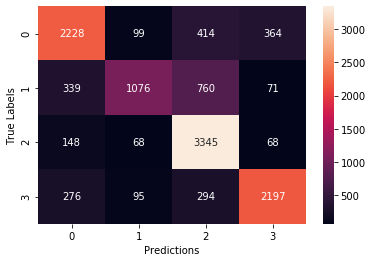

In [84]:
sns.heatmap(confusion_matrix(y_test, ypred_nb),fmt = 'd', annot = True)
plt.xlabel('Predictions')
plt.ylabel('True Labels')

### 5.2 Avaliação Individual para o Modelo SVM 

In [85]:
print('Accuracy SVM:', accuracy_score(y_test, ypred_svm))
print('Precision SVM:', precision_score(y_test, ypred_svm, average = 'macro' ))
print('Kappa Score SVM:', cohen_kappa_score(y_test, ypred_svm))

Accuracy SVM: 0.8286606992062152
Precision SVM: 0.8280442284832222
Kappa Score SVM: 0.768157746557588


In [86]:
print(classification_report(y_test, ypred_svm))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      3105
           1       0.80      0.67      0.73      2246
           2       0.81      0.90      0.86      3629
           3       0.88      0.85      0.86      2862

    accuracy                           0.83     11842
   macro avg       0.83      0.81      0.82     11842
weighted avg       0.83      0.83      0.83     11842



Text(33.0, 0.5, 'True Labels')

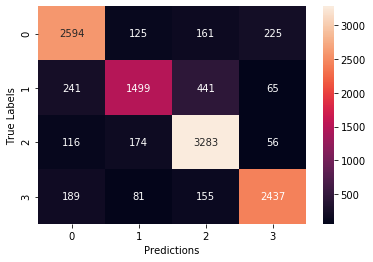

In [87]:
sns.heatmap(confusion_matrix(y_test, ypred_svm),fmt = 'd', annot = True)
plt.xlabel('Predictions')
plt.ylabel('True Labels')

### 5.3 Cross-Validation

### CV - Multinomial Naive Bayes

In [91]:
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df[['clean_posts']], df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer()

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'].apply(lambda x: np.str_(x)))) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts'].apply(lambda x: np.str_(x))))
    
    model = MultinomialNB()
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
mnb_model = {
            'Model' : 'Multinomial NB',
            'Transformação': 'TF-IDF nas palavras',
            'Accuracy': '{:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)),
            'Precision': '{:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)),
            'Kappa Score': '{:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list))}

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [92]:
print('Cross-Validation MNB Evaluation:')
print('Accuracy MNB: {:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision MNB: {:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score MNB: {:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation MNB Evaluation:
Accuracy MNB: 0.756 +/- 0.002
Precision MNB: 0.769 +/- 0.003
Kappa Score MNB: 0.666 +/- 0.003


### CV - SVM c/ Kernel Linear

In [93]:
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df[['clean_posts']], df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer()

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'].apply(lambda x: np.str_(x)))) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts'].apply(lambda x: np.str_(x))))
    
    model = SVC(kernel='linear')
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
svm_model = {'Model' : 'SVM - Kernel Linear',
            'Transformação': 'TF-IDF nas palavras',
            'Accuracy': '{:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)),
            'Precision': '{:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)),
            'Kappa Score': '{:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list))}    

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [94]:
print('Cross-Validation SVM Evaluation:')
print('Accuracy SVM: {:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision SVM: {:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score SVM: {:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation SVM Evaluation:
Accuracy SVM: 0.837 +/- 0.003
Precision SVM: 0.834 +/- 0.004
Kappa Score SVM: 0.779 +/- 0.004


## 6.0 Comparativo dos modelos testados:


In [95]:
comp_models = [mnb_model, svm_model]

In [96]:
pd.DataFrame(comp_models, index=np.arange(0, len(comp_models)))

,Model,Transformação,Accuracy,Precision,Kappa Score
0,Multinomial NB,TF-IDF nas palavras,0.756 +/- 0.002,0.769 +/- 0.003,0.666 +/- 0.003
1,SVM - Kernel Linear,TF-IDF nas palavras,0.837 +/- 0.003,0.834 +/- 0.004,0.779 +/- 0.004


## Sugestões de Melhorias:

- ~~Utilização de SVM c/ Linear Kernel~~
- Utilização de Bigramas ou Trigramas antes da transformação TF-IDF com o MultinomialNB ou o SVM LK
- Utilização de Redes Neurais - LSTM
- SMOTE para um melhor balanceamento das classes
- Análise da Nuvem de palavras pra cada classe, a fim de identificar quais termos aparecem com mais frequência dependendo da classe.